## Tensorflow Distributions: Gentle Introduction

In [1]:
import collections

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfe = tf.contrib.eager

try:
    tfe.enable_eager_execution()
except ValueError:
    pass

import matplotlib.pyplot as plt

### Basic Univariate Distributions
Let's dive right in and create a normal distribution:

In [2]:
n = tfd.Normal(loc=0., scale=1.)
n

<tfp.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float32>

We can draw a sample from it:

In [3]:
n.sample()

<tf.Tensor: id=23, shape=(), dtype=float32, numpy=-1.1924932>

We can draw multiple samples:

In [4]:
n.sample(3)

<tf.Tensor: id=47, shape=(3,), dtype=float32, numpy=array([0.52447134, 0.08630355, 0.23621958], dtype=float32)>

In [5]:
n.log_prob(0.)

<tf.Tensor: id=59, shape=(), dtype=float32, numpy=-0.9189385>

We can evaluate multiple log probabilities

In [7]:
n.log_prob([0., 2., 4.])

<tf.Tensor: id=70, shape=(3,), dtype=float32, numpy=array([-0.9189385, -2.9189386, -8.918939 ], dtype=float32)>

We have a wide range of distributions. Let's try a Bernoulli:

In [8]:
b = tfd.Bernoulli(probs=0.7)
b

<tfp.distributions.Bernoulli 'Bernoulli/' batch_shape=() event_shape=() dtype=int32>

In [9]:
b.sample()

<tf.Tensor: id=99, shape=(), dtype=int32, numpy=1>

In [10]:
b.sample(8)

<tf.Tensor: id=124, shape=(8,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)>

In [11]:
b.log_prob(1)

<tf.Tensor: id=140, shape=(), dtype=float32, numpy=-0.35667494>

In [12]:
b.log_prob([1, 0, 1, 0])

<tf.Tensor: id=163, shape=(4,), dtype=float32, numpy=array([-0.35667494, -1.2039728 , -0.35667494, -1.2039728 ], dtype=float32)>

### Multivariate Distributions
We can create multivariate normal with a diagonal covariance:

In [15]:
nd = tfd.MultivariateNormalDiag(loc=[0., 10.], scale_diag=[1, 4])

Comparing this to the univariate normal we created earlier, what's the difference?

In [16]:
tfd.Normal(loc=0., scale=1.)

<tfp.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float32>

In [17]:
nd

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag/' batch_shape=() event_shape=(2,) dtype=float32>

We see that the univariate normal has an `event_shape` of `()`, indicating it is a scalar distribution. The multivariate normal has an `event_shape` of 2, indicating the basic event space of this distribution is two-dimensional.

Sampling works just as before:

In [18]:
nd.sample()

<tf.Tensor: id=287, shape=(2,), dtype=float32, numpy=array([ 0.43148044, 10.18098   ], dtype=float32)>

In [19]:
nd.sample(5)

<tf.Tensor: id=341, shape=(5, 2), dtype=float32, numpy=
array([[-0.06153893, 15.1066065 ],
       [-0.06185818,  7.6507425 ],
       [-0.9261941 , 11.718234  ],
       [ 0.8977586 , 14.193409  ],
       [ 0.56684786, 13.409323  ]], dtype=float32)>

In [20]:
nd.log_prob([0., 10.])

<tf.Tensor: id=393, shape=(), dtype=float32, numpy=-3.2241714>

Multivariate normals do not in general have diagonal covariance. TFD offers multiple ways to create multivariate normals, including a full-covariance specification:

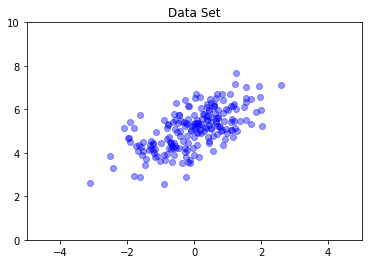

In [2]:
nd = tfd.MultivariateNormalFullCovariance(loc=[0., 5.],
                                         covariance_matrix = [[1., 7.], [.7, 1.]])
data = nd.sample(200)
plt.scatter(data[:, 0], data[:, 1], color='blue', alpha=0.4)
plt.axis([-5, 5, 0, 10])
plt.title('Data Set')
plt.show()

### Multiple Distributions
Our first Bernoulli distribution represented a flip of a single fair coin. We can also create a batch of independent Bernoulli distributions, each with their own parameters, in a single `Distribution` object:

In [3]:
b3 = tfd.Bernoulli(probs=[.3, .5, .7])
b3

<tfp.distributions.Bernoulli 'Bernoulli/' batch_shape=(3,) event_shape=() dtype=int32>

It's important to be clear on what this means. The above call defines three independent Bernoulli distributions, which happen to be contained in the same Python `Distribution` object. The three distributions cannot be manipulated individually. Note how the `batch_shape` is `(3,)`, indicating a batch of three distributions, and the `event_shape` is `()` indicating individual distributions have a univariate event space.

If we call `sample`, we get a sample from all three:

In [4]:
b3.sample()

<tf.Tensor: id=193, shape=(3,), dtype=int32, numpy=array([0, 0, 1], dtype=int32)>

In [5]:
b3.sample(6)

<tf.Tensor: id=218, shape=(6, 3), dtype=int32, numpy=
array([[1, 0, 1],
       [0, 0, 0],
       [0, 1, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1]], dtype=int32)>

If we call `prob`, (this has the same shape semantics as `log_prob`; we use `prob` with these small Bernoulli examples for clarity, although `log_prob` is usually preferred in applications) we can pass it a vector and evaluate the probability of each coin yielding that value:

In [6]:
b3.prob([1, 1, 0])

<tf.Tensor: id=235, shape=(3,), dtype=float32, numpy=array([0.29999998, 0.5       , 0.29999998], dtype=float32)>

Why does the API include batch shape? Semantically, one could perform the same computations by creating a list of distributions and iterating over them with a `for` loop (at least in Eager mode, in TF graph mode you'd need a `tf.while` loop). However, having a (potentially large) set of identically parameterized distribution is extremely common, and the use of vectorized computations whenever possible is a key ingredient in being able to perform fast computations using hardware accelerators.

### Using Independent To Aggregate Batches to Events

In the previous section, we created `b3`, a single `Distribution` object that represented three coin flips. If we called `b3.prob` on a vector $v$, the $i$'th entry was the probability that the $i$th coin takes value $v[i]$.

Suppose we'd instead like to specify a 'joint' distribution over independent random variables from the same underlying family. This is a different object mathematically, in that for this new distribution, `prob` on a vector $v$ will return a single value representing the probability that the entire set of coins matches the vector $v$.

How do we accomplish this? We use a 'higher-order' distribution called `Independent`, which takes a distribution and yields a new distribution with the batch shape moved to the event shape:

In [7]:
b3_joint = tfd.Independent(b3, reinterpreted_batch_ndims=1)
b3_joint

<tfp.distributions.Independent 'IndependentBernoulli/' batch_shape=() event_shape=(3,) dtype=int32>

In [8]:
b3

<tfp.distributions.Bernoulli 'Bernoulli/' batch_shape=(3,) event_shape=() dtype=int32>

As promised, we see that `Independent` has moved the batch shape into the event shape: `b3_joint` is a single distribution `(batch_shape = ())` over a three-dimensional event space (`event_shape=(3,)`).

Let's check the semantics:

In [9]:
b3_joint.prob([1, 1, 0])

<tf.Tensor: id=256, shape=(), dtype=float32, numpy=0.044999998>

An alternate way to get the same result would be to compute probabilities using `b3` and do the reduction manually by multiplying (or, in the more usual case where log probabilities are used, summing):

In [10]:
tf.reduce_prod(b3.prob([1, 1, 0]))

<tf.Tensor: id=274, shape=(), dtype=float32, numpy=0.044999994>

`Independent` allows the user to more explicitly represent the desired concept. We view this as extremely useful, althought it's not strictly necessary.

### Batches of Multivariate Distributions
Let's create a batch of three full-covariance two-dimensional multivariate normals:

In [11]:
nd_batch = tfd.MultivariateNormalFullCovariance(
    loc=[[0., 0.], [1., 1.,], [2., 2.]],
    covariance_matrix = [[[1., .1], [.1, 1.]],
                        [[1., .3], [.3, 1.]],
                        [[1., .5], [.5, 1.]]])
nd_batch

<tfp.distributions.MultivariateNormalFullCovariance 'MultivariateNormalFullCovariance/' batch_shape=(3,) event_shape=(2,) dtype=float32>

We see `batch_shape = (3,)`, so there are three independent multivariate normals, and `event_shape = (2,)`, so each multivariate normal is two-dimensional. In this example, the individual distributions do not have independent elements.

Sampling works:

In [12]:
nd_batch.sample(4)

<tf.Tensor: id=414, shape=(4, 3, 2), dtype=float32, numpy=
array([[[-1.0709534 ,  0.10533298],
        [ 1.2670178 , -0.08477736],
        [ 1.1350889 ,  1.1963141 ]],

       [[-0.25410712, -0.55836666],
        [ 0.4644633 ,  1.087798  ],
        [ 1.165742  ,  2.3444371 ]],

       [[-0.3545381 , -0.82905924],
        [ 1.1922708 ,  0.467659  ],
        [ 1.325767  ,  0.924829  ]],

       [[-0.3278344 , -0.25853413],
        [ 1.7886593 ,  0.9183414 ],
        [ 1.8631281 ,  1.5512732 ]]], dtype=float32)>

Since `batch_shape = (3,)` and `event_shape=(2,)`, we pass a tensor of shape `(3, 2)` to `log_prob`:

In [13]:
nd_batch.log_prob([[0., 0.], [1., 1.], [2., 2.]])

<tf.Tensor: id=462, shape=(3,), dtype=float32, numpy=array([-1.8328519, -1.7907217, -1.694036 ], dtype=float32)>

## Broadcasting, aka Why Is This So Confusing?

Abstract out what we've done so far, every distribution has an batch shape `B` and an event shape `E`. Let `BE` be the concatenation of the event shapes:
* For the univariate scalar distributions `n` and `b`, `BE = ()`
* For the two-dimensional multivariate normals `nd.BE = (2)`
* For both `b3` and `b3_joint`, `BE=(3).`
* For the batch of multivariate normals `ndb`, `BE = (3, 2)`.

The evaluation rules we've been using so far are:
* Sample with no argument returns a tensor with shape `BE`; sampling with a scalar `n` returns an `n x BE` tensor.
* `prob` and `log_prob` take a tensor of shape `BE` and return a result of shape `B`.

The actual 'evaluation rule' for `prob` and `log_prob` is more complicated, in a way that offers potential power and speed but also complexity and challenges. The actual rule is (essentially) that **the argument to `log_prob` *must* be *broadcastable* against `BE`; any 'extra' dimensions are preserved in the output.**

Let's explore the implications. For the univariate normal `n`, `BE=()`, so `log_prob` expects a scalar. If we pass `log_prob` a tensor with non-empty shape, those show up as batch dimensions in the output:

In [14]:
n = tfd.Normal(loc=0., scale=1.)
n

<tfp.distributions.Normal 'Normal/' batch_shape=() event_shape=() dtype=float32>

In [15]:
n.log_prob(0.)

<tf.Tensor: id=476, shape=(), dtype=float32, numpy=-0.9189385>

In [16]:
n.log_prob([0.])

<tf.Tensor: id=487, shape=(1,), dtype=float32, numpy=array([-0.9189385], dtype=float32)>

In [17]:
n.log_prob([[0., 1.], [-1., 2.]])

<tf.Tensor: id=498, shape=(2, 2), dtype=float32, numpy=
array([[-0.9189385, -1.4189385],
       [-1.4189385, -2.9189386]], dtype=float32)>

Let's turn to the 2-D multivariate normal `nd` 

In [18]:
nd = tfd.MultivariateNormalDiag(loc=[0., 1.], scale_diag=[1, 1])
nd

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag/' batch_shape=() event_shape=(2,) dtype=float32>

`log_prob` 'expects' an argument with shape `(2,)` but it will accept any argument that broadcasts against this shape:

In [19]:
nd.log_prob([0., 0.])

<tf.Tensor: id=619, shape=(), dtype=float32, numpy=-2.337877>

But we can pass in 'more' examples, and evaluate all their `log_prob`s at once:

In [20]:
nd.log_prob([[0., 0.],
            [1., 1.],
            [2., 2.]])

<tf.Tensor: id=645, shape=(3,), dtype=float32, numpy=array([-2.337877 , -2.337877 , -4.3378773], dtype=float32)>

Perhaps less appealingly, we can broadcast over the event dimensions:

In [21]:
nd.log_prob([0.])

<tf.Tensor: id=671, shape=(), dtype=float32, numpy=-2.337877>

In [22]:
nd.log_prob([[0], [1.], [2.]])

<tf.Tensor: id=697, shape=(3,), dtype=float32, numpy=array([-2.337877 , -2.337877 , -4.3378773], dtype=float32)>

Now let's look at the three coins example again:

In [23]:
b3 = tfd.Bernoulli(probs=[.3, .5, .7])

Here, using broadcasting to represent the probability that *each* coin comes up heads is quite intuitive:

In [24]:
b3.prob([1])

<tf.Tensor: id=728, shape=(3,), dtype=float32, numpy=array([0.29999998, 0.5       , 0.7       ], dtype=float32)>

Now suppose we want to know, for each coin, the probability the coin comes up heads *and* the probability it comes up tails. We could imagine trying:
`b3.log_prob([0, 1])`
Unfortunately this produces an error. `b3` has `BE = (3,)`, so we must pass `b3.prob` something broadcastable against `(3,)`. `[0, 1]` has shape `(2)`, so it doesn't broadcast and creates an error. Instead, we have to say:

In [25]:
b3.prob([[0], [1]])

<tf.Tensor: id=752, shape=(2, 3), dtype=float32, numpy=
array([[0.7, 0.5, 0.3],
       [0.3, 0.5, 0.7]], dtype=float32)>

Why? `[[0, 1]]` has shape `(2, 1)` so it broadcasts against shape `(3)` to make a broadcast shape of `(2, 3)`.

Broadcasting is quite powerful: there are cases where it allows order-of-magnitude reduction in the amount of memory used and it often makes user code shorter. However, it can be challenging to program with. If you call `log_prob` and get an error, a failure to broadcast is nearly always the problem.